# Introduction
This notebook aims at evaluating the (DI+LLM) technique for entity extraction from Tax Documents. We use schema2doc mapping based on Document Intelligence (DI) output of the processed document. DI provides a JSON or Markdown output format, including the styles information. Using LLM prompting, we ask the LLM (GPT4o) to process the DI output and provide a JSON format with the defined schema. 

### Imports

In [2]:
## IMPORTING PACKAGES
import os 
from dotenv import load_dotenv
import warnings  
from pprint import pprint

from tqdm import tqdm
import pandas as pd
import regex as re  
import json
import time

from azure.core.credentials import AzureKeyCredential  
from azure.ai.documentintelligence import DocumentIntelligenceClient 
from azure.ai.documentintelligence.models import  DocumentAnalysisFeature  

from openai import AzureOpenAI

from langchain.docstore.document import Document  
from langchain_openai import AzureOpenAIEmbeddings  
from langchain.vectorstores.azuresearch import AzureSearch  
from langchain.text_splitter import MarkdownTextSplitter

import tiktoken

## Suppress warnings  
warnings.filterwarnings("ignore")  

%reload_ext autoreload
%autoreload 2

### Settings
Provide your API keys in the .env file

In [3]:
## CREDENTIALS
load_dotenv()

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
DEPLOYMENT_NAME = os.getenv("DEPLOYMENT_NAME")

DOC_INTELLIGENCE_ENDPOINT = os.getenv("DOC_INTELLIGENCE_ENDPOINT")
DOC_INTELLIGENCE_KEY = os.getenv("DOC_INTELLIGENCE_KEY")

VECTOR_SEARCH_ENDPOINT = os.getenv("VECTOR_SEARCH_ENDPOINT")
VECTOR_SEARCH_KEY = os.getenv("VECTOR_SEARCH_KEY")

### RAG Components

In [4]:
## 1. APPLY DOCUMENT INTELLIGENCE
def document_layout_analysis(document_path, di_endpoint=DOC_INTELLIGENCE_ENDPOINT, di_key=DOC_INTELLIGENCE_KEY):
    doc_intelligence_client = DocumentIntelligenceClient(endpoint=di_endpoint, 
                                                        credential=AzureKeyCredential(di_key))
    if document_path.endswith('.html'): ## Styles feature currently is not supported for HTML files
        features=[]
    elif document_path.endswith('.pdf'):
        features=[DocumentAnalysisFeature.STYLE_FONT]
        
    with open(document_path, "rb") as f:  
        poller = doc_intelligence_client.begin_analyze_document(  
            "prebuilt-layout",  
            f,
            content_type="application/octet-stream",  
            output_content_format="markdown",
            features=features
            
        )
    result = poller.result()  
    return result

document_name = "2020_Apr_George.pdf"
results = document_layout_analysis(os.path.join("data\documents", document_name))
print(results['content'])

ServiceRequestError: No connection adapters were found for 'YOUR_RESOURCE_ENDPOINT_HERE/documentintelligence/documentModels/prebuilt-layout:analyze?api-version=2024-02-29-preview&features=styleFont&outputContentFormat=markdown'

In [15]:
## STORING DOCUMENT INTELLIGENECE OUTPUT
def store_analysis(di_response, folder_path, filename):
    for key in di_response.keys():  
        with open(os.path.join(folder_path, f"{filename}_{key.upper()}.md"), "w", encoding="utf-8") as file:  
            file.write(str(di_response[key]))  

store_analysis(results, "", document_name[:-4])

In [16]:
## 2. ADD STYLE TAGS TO THE TEXTUAL CONTENT
def apply_tags_to_content(content, styles):
    def merge_spans(spans):
        if not spans:
            return []
        merged_spans = [spans[0]]
        for current in spans[1:]:
            last = merged_spans[-1]
            if last['offset'] + last['length'] >= current['offset']:
                merged_spans[-1] = {
                    'offset': last['offset'],
                    'length': max(last['length'], current['offset'] + current['length'] - last['offset'])
                }
            else:
                merged_spans.append(current)
        return merged_spans

    color_spans = []
    background_color = []
    font_weight_spans = []

    for style in styles:
        for span in style['spans']:
            if 'color' in style:
                color_spans.append({'offset': span['offset'], 'length': span['length'], 'color': style['color']})
            if 'backgroundColor' in style:
                background_color.append({'offset': span['offset'], 'length': span['length'], 'backgroundColor': style['backgroundColor']})
            if ('fontWeight' in style) and (style['fontWeight']=='bold'):
                font_weight_spans.append({'offset': span['offset'], 'length': span['length'], 'fontWeight': style['fontWeight']})

    merged_color_spans = merge_spans(sorted(color_spans, key=lambda x: x['offset']))
    merged_backgroundcolor_spans = merge_spans(sorted(background_color, key=lambda x: x['offset']))
    merged_font_weight_spans = merge_spans(sorted(font_weight_spans, key=lambda x: x['offset']))
    
    tags = []

    for span in merged_color_spans:
        tags.append((span['offset'], f"<color: {span['color']}>"))
        tags.append((span['offset'] + span['length'], "</color>"))
        tags.append((span['offset'], f"<offsets: {span['offset']},{span['offset']+span['length']}>"))
        
    for span in merged_backgroundcolor_spans:
        tags.append((span['offset'], f"<backgroundcolor: {span['backgroundColor']}>"))
        tags.append((span['offset'] + span['length'], "</backgroundcolor>"))
        
    for span in merged_font_weight_spans:
        tags.append((span['offset'], f"<font_style: {span['fontWeight']}>"))
        tags.append((span['offset'] + span['length'], "</font_style>"))

    tags = list(set(tags))
    tags.sort(key=lambda x: x[0])

    tagged_content = []
    last_index = 0
    for offset, tag in tags:
        tagged_content.append(content[last_index:offset])
        tagged_content.append(tag)
        last_index = offset

    tagged_content.append(content[last_index:])

    return ''.join(tagged_content)

updated_content = apply_tags_to_content(results['content'], results['styles'])
print(updated_content)

<figure>

![](figures/0)

<!-- FigureContent="<backgroundcolor: #fafafa><color: #414141><offsets: 46,59>Department of</backgroundcolor></color> <font_style: bold><color: #050505><offsets: 60,67><backgroundcolor: #f8f8f8>Revenue</font_style></color> <offsets: 68,78><color: #5d5d5d>Washington</color> <offsets: 79,84><color: #555555>State</backgroundcolor></color>" -->

</figure>


<backgroundcolor: #fefefe><offsets: 103,141><color: #0d0dfd>WASHINGTON STATE DEPARTMENT OF REVENUE</color> <color: #0101fd><offsets: 142,164>LOCAL SALES TAX CHANGE</color></backgroundcolor>

<font_style: bold><backgroundcolor: #fefefe><offsets: 166,236><color: #010101>City of George Transportation Benefit District Effective April 1, 2020</color></font_style></backgroundcolor>
===

<offsets: 242,266><font_style: bold><backgroundcolor: #fefefe><color: #010101>Effective April 1, 2020,</font_style></color> <color: #0d0d0d><offsets: 267,275>the City</color> <offsets: 276,278><color: #050505>of</color> <color: #09090

In [17]:
## 3. SEMANTIC CHUNKING
## Using Byte Pair Encoding for Better Grammar understanding
class TokenEstimator(object):
    GPT2_TOKENIZER = tiktoken.encoding_for_model("gpt-4")
    def estimate_tokens(self, text):
        return len(self.GPT2_TOKENIZER.encode(text, allowed_special="all"))

    def construct_tokens_with_size(self, tokens, numofTokens):
        newTokens = self.GPT2_TOKENIZER.decode(
            self.GPT2_TOKENIZER.encode(tokens, allowed_special="all")[:numofTokens]
        )
        return newTokens

def merge_chunks_serially(chunked_content_list, num_tokens):
    current_chunk = ""
    total_size = 0
    TOKEN_ESTIMATOR = TokenEstimator()
    for chunked_content in chunked_content_list:
        chunk_size = TOKEN_ESTIMATOR.estimate_tokens(chunked_content)
        if total_size > 0:
            new_size = total_size + chunk_size
            if new_size > num_tokens:
                yield current_chunk, total_size
                current_chunk = ""
                total_size = 0
        total_size += chunk_size
        current_chunk += chunked_content
    if total_size > 0:
        yield current_chunk, total_size

def semantic_chunking(document, file_name, num_tokens=128000, token_overlap=64000):
    
    splitter = MarkdownTextSplitter.from_tiktoken_encoder(
    chunk_size=num_tokens, chunk_overlap=token_overlap)
    if 'styles' in document:
        content = apply_tags_to_content(document['content'], document['styles'])
    else:
        content = document['content']
    chunked_content_list = splitter.split_text(
        content)
    
    chunks = []
    for chunked_content, chunk_size in merge_chunks_serially(chunked_content_list, num_tokens):
        chunks.append(Document(page_content=chunked_content.strip(), metadata={"source": f"{file_name[1]}.md", "chunk_size": chunk_size}))
    print(f"NUMBER OF RESULTED CHUNKS: {len(chunks)}")
    return chunks 

chunks = semantic_chunking(results, document_name)

NUMBER OF RESULTED CHUNKS: 1


In [18]:
## OPTIONAL
""" ChUNKS EMBEDDINGS & INDEXING """
def indexing(document_chunks, index_name):
    embeddings = AzureOpenAIEmbeddings(  
        azure_deployment="text-embedding-ada-002",  
        openai_api_version="2023-12-01-preview"  
    )  
    
    index_name = index_name
    
    vector_store = AzureSearch(azure_search_endpoint=VECTOR_SEARCH_ENDPOINT,  
                               azure_search_key=VECTOR_SEARCH_KEY,  
                               index_name=index_name,  
                               embedding_function=embeddings.embed_query  
    )
    
    vector_store.add_documents(documents=document_chunks)
    return vector_store

In [19]:
## 4. LLM CALL
## LLM Call
def get_aoai_response(query, force_json=False, prompt_file="prompt.json"):
    endpoint = AZURE_OPENAI_ENDPOINT
    deployment = DEPLOYMENT_NAME
    api_key=AZURE_OPENAI_API_KEY
    MAX_NUM_RETRIES = 3 
    client = AzureOpenAI(
        azure_endpoint=endpoint,
        api_key=api_key,
        api_version="2024-02-01",
    )
    
    with open(prompt_file, "r") as file:
        prompt_template = file.read()
    prompt = prompt_template.format(context=query)
    # Implement retries 
    for i in range(MAX_NUM_RETRIES):
        try:
            if force_json:
                completion = client.chat.completions.create(
                        model=deployment,
                        messages=[                                 
                            {
                                "role": "user",
                                "content": prompt
                            }
                        ],
                        temperature=0.0,
                        response_format={"type": "json_object"}
                        ) 
            else:
                completion = client.chat.completions.create(
                        model=deployment,
                        messages=[                                    
                            {
                                "role": "user",
                                "content": prompt
                            }
                        ],
                        temperature=0.0
                        )
            break
        except Exception as e:
            print(f"Error: {e}")
            print(f"Retrying AOAI call {i}...")
            time.sleep(21)
    return completion.choices[0].message.content

#### HELPER FUNCTIONS

In [20]:
## CLEAN LLM JSON RESPONSES
def clean_llm_response(response, force_json=False):
    if not force_json:
        try:
            ## Use regex to find the JSON part of the response
            json_match = re.search(r'\[\s*{.*}\s*\]', response, re.DOTALL)
            if json_match:
                json_str = json_match.group(0)
                return json_str.replace("```", "").replace("json","")
            else:
                raise ValueError("No valid JSON found in the response.")
        except (SyntaxError, ValueError) as e:
            print(f"Error parsing response: {e} \n Response: {response}")
            return []
        
    else:
        return json.dumps(eval(response))#['results'])

In [21]:
## GET LLM RESPONSE
def get_llm_response(query, force_json=False, prompt_file="prompt.json") -> str:
    response = get_aoai_response(query, force_json, prompt_file)
    cleaned_response = clean_llm_response(response, force_json)    
    return cleaned_response

In [22]:
## WRITE PREDICTIONS IN JSON
def write_preds(DF, pred, file_name, force_json):
    DF.reset_index(drop=True, inplace=True)
    DF['predictions'] = clean_llm_response(pred, force_json)
    DF.to_csv(os.path.join("", file_name), sep='\t', index=False)

##### SAMPLE DOCUMENT ANALYSIS

In [25]:
## SETTINGS
eval_tsv = "ground_truth.tsv"
folder_path = "data\documents"
prompt_file = "prompt_grounding.txt" 
experiment_name = document_name[:-4]
force_json = False

In [26]:
output_folder = os.path.join('data', experiment_name)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [27]:
## LOAD GROUND TRUTH
DF = pd.read_csv(eval_tsv, sep='\t')

DF = DF[DF['document_url'] == document_name]
DF = DF.reset_index(drop=True)
global_pred = []
filenames = DF['document_url']
for file in tqdm(filenames):
    print(file)
    document = os.path.join(folder_path, file)
    file_name = os.path.basename(file).split('.')[0]
    di_response = document_layout_analysis(document)
    chunks = semantic_chunking(di_response, file_name) 
    tax_changes_chunks = []    
    for chunk in tqdm(chunks):
        content = chunk.page_content
        tax_changes = get_llm_response(content, force_json, prompt_file)
        tax_changes_chunks.extend(eval(tax_changes))
        
    global_pred.append(json.loads(json.dumps(tax_changes_chunks)))

## DISPLAY EXTRACTED TAX RECORDS
print()
pprint(global_pred)

  0%|          | 0/1 [00:00<?, ?it/s]

2020_Apr_George.pdf
NUMBER OF RESULTED CHUNKS: 1


100%|██████████| 1/1 [00:20<00:00, 20.27s/it]


[[{'effective_from': {'item': 'April 1, 2020', 'offsets': ['166', '236']},
   'expire_date': {'item': '', 'offsets': ['', '']},
   'jurisdiction': {'item': 'City of George', 'offsets': ['267', '285']},
   'new_rate': {'item': '.002', 'offsets': ['426', '433']},
   'parent_city': {'item': '', 'offsets': ['', '']},
   'parent_county': {'item': '', 'offsets': ['', '']},
   'parent_state': {'item': 'Washington', 'offsets': ['68', '78']},
   'polity_type': {'item': 'City', 'offsets': ['267', '285']},
   'target': {'item': 'Sales and use tax', 'offsets': ['342', '366']}},
  {'effective_from': {'item': 'April 1, 2020', 'offsets': ['166', '236']},
   'expire_date': {'item': '', 'offsets': ['', '']},
   'jurisdiction': {'item': 'George TBD', 'offsets': ['1136', '1146']},
   'new_rate': {'item': '.019', 'offsets': ['1156', '1160']},
   'parent_city': {'item': 'George', 'offsets': ['267', '285']},
   'parent_county': {'item': '', 'offsets': ['', '']},
   'parent_state': {'item': 'Washington', 'o

In [28]:
## WRITE PREDICTIONS VS. GROUND TRUTH
predictions_file_name = document_name + '.tsv'
DF_copy = DF.copy()
DF_copy.reset_index(drop=True, inplace=True)
DF_copy['predictions'] = json.dumps(global_pred)
json_schema_string = '[{"jurisdiction": "", "target": "", "new_rate": "", "expire_date": "", "effective_from": "", "polity_type": "", "parent_city": "", "parent_county": "", "parent_state": ""}]'
DF_copy.replace("[]", json_schema_string, inplace=True)
DF_copy.to_csv(os.path.join("", os.path.join(output_folder, predictions_file_name)), sep='\t', index=False)

1
Added entity jurisdiction: Precision=75.0, Recall=100.0, F1-Score=85.71
Added entity effective_from: Precision=75.0, Recall=100.0, F1-Score=85.71
Added entity effective_to: Precision=75.0, Recall=100.0, F1-Score=85.71
Added entity new_rate: Precision=75.0, Recall=100.0, F1-Score=85.71
Added entity target: Precision=75.0, Recall=100.0, F1-Score=85.71
Added entity polity_type: Precision=0.0, Recall=0.0, F1-Score=nan
Added entity parent_state: Precision=0.0, Recall=0.0, F1-Score=nan
Added entity parent_county: Precision=0.0, Recall=0.0, F1-Score=nan
Added entity parent_city: Precision=0.0, Recall=0.0, F1-Score=nan


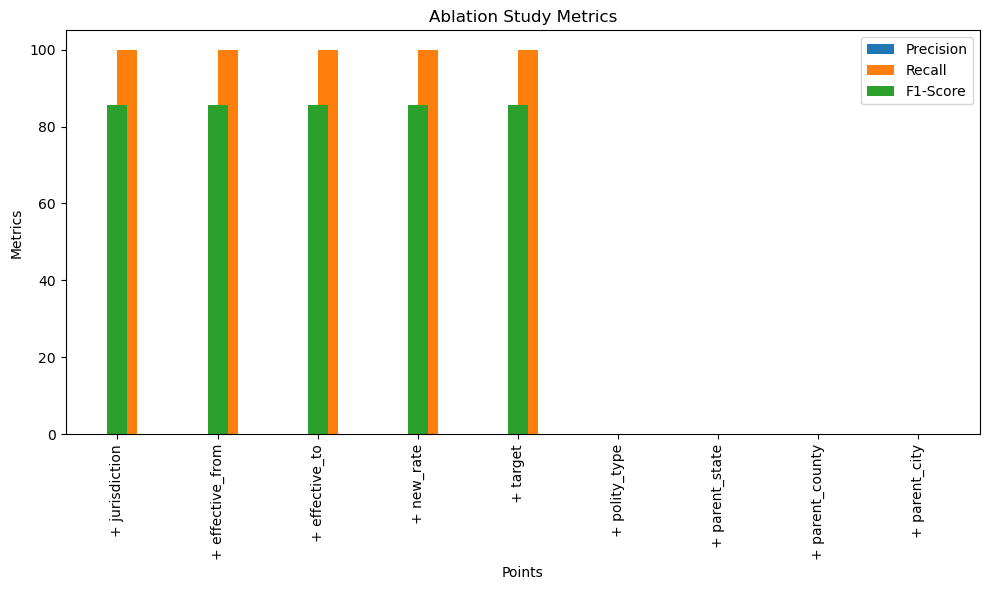

Entity jurisdiction: Precision=75.0, Recall=100.0, F1-Score=85.71
Entity effective_from: Precision=100.0, Recall=100.0, F1-Score=100.0
Entity effective_to: Precision=100.0, Recall=100.0, F1-Score=100.0
Entity new_rate: Precision=75.0, Recall=100.0, F1-Score=85.71
Entity target: Precision=75.0, Recall=100.0, F1-Score=85.71
Entity polity_type: Precision=0.0, Recall=0.0, F1-Score=nan
Entity parent_state: Precision=100.0, Recall=100.0, F1-Score=100.0
Entity parent_county: Precision=100.0, Recall=100.0, F1-Score=100.0
Entity parent_city: Precision=100.0, Recall=100.0, F1-Score=100.0


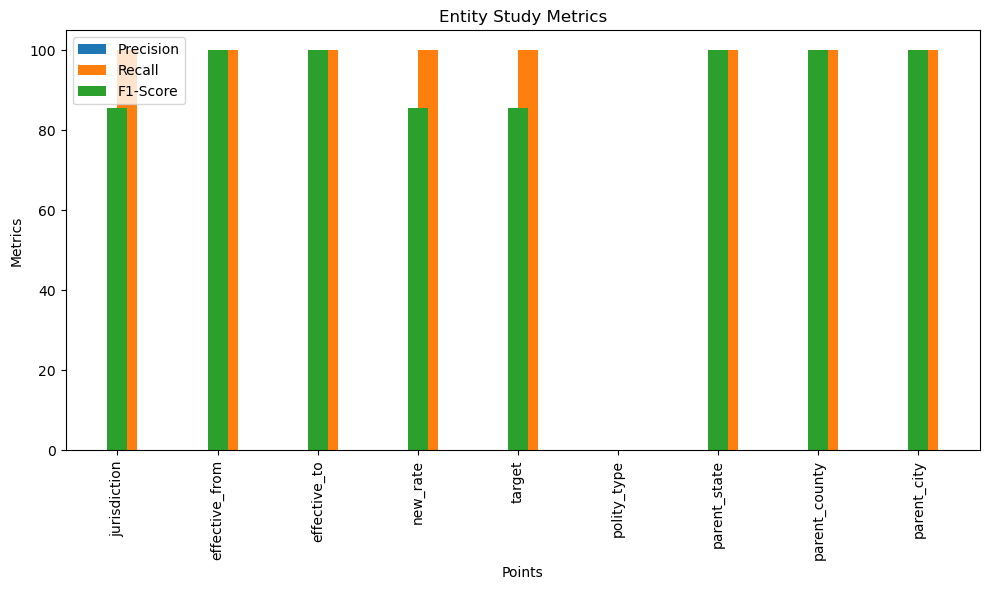

In [23]:
model_predictions_path = os.path.join(output_folder, predictions_file_name)
%run evaluation_study_grounding.py $model_predictions_path